In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx

def prolog_to_pyg(file_path):
    countries = {}
    country_features = {}
    borders = set()
    country_id = 0 
    # Créer un dictionnaire de mappage pour mapper chaque continent à un identifiant unique
    continent_to_id = {'Africa': 0, 'Asia': 1, 'Europe': 2, 'North America': 3, 'South America': 4, 'Oceania': 5, 'Antarctica': 6}
    # Créer un dictionnaire de mappage pour mapper chaque religion à un identifiant unique
    religion_to_id = {'Muslim': 0, 'Christian Orthodox': 1, 'Catholic': 2, 'Buddhist': 3, 'Protestant': 4, 'Hindu': 5, 'Jewish': 6, 'Tewahedo Christian Orthodox': 7, 'Indigenous Beliefs': 8, 'Vietnamese Folk Religion': 9, 'Korean Shamanism': 10}
    religion_labels =[]

    with open(file_path, "r",encoding="utf-8") as file:
        for line in file:
            parts = line.strip().split("(")
            if len(parts) < 2:
                continue
            
            predicate = parts[0]
            arguments = parts[1].split(")")[0].split(",")
            
            if predicate == 'country':
                country_code = arguments[1].strip("'")
                country_name = arguments[0].strip("'")
                countries[country_code] = country_name 
                area = float(arguments[4]) if arguments[4] != 'null' else 0
                population = float(arguments[5]) if arguments[5] != 'null' else 0
                country_features[country_code] = {'Area': area,'Population':population}
    
            
            elif predicate == 'population':
                country_code = arguments[0].strip("'")
                population_growth = float(arguments[1]) if arguments[1] != 'null' else 0
                infant_mortality = float(arguments[2]) if arguments[2] != 'null' else 0
                if country_code in country_features:
                    country_features[country_code].update({'Population_Growth': population_growth, 'Infant_Mortality': infant_mortality})
                else:
                    country_features[country_code] = {'Population_Growth': population_growth, 'Infant_Mortality': infant_mortality}
            
            elif predicate == 'politics':
                country_code = arguments[0].strip("'")
                independence = arguments[1].strip("'")
                dependent = arguments[2].strip("'")
                government = arguments[4].strip("'")
                country_features[country_code].update({'Independence': independence, 'Dependent': dependent, 'Government': government})
                
            elif predicate == 'religion':
                country_code = arguments[0].strip("'")
                religion = arguments[1].strip("'")
                percentage = float(arguments[2]) if arguments[2] != 'null' else 0
                # Assurez-vous que percentage respecte la contrainte de la table religion
                if country_code in country_features:
                    country_features[country_code].update({'Religion': religion, 'Percentage': percentage})
                    # Convertir le nom de la religion en son identifiant correspondant
                    religion_id = religion_to_id.get(religion, 0)
                    country_features[country_code].update({'Religion_ID': religion_id})
                    # Ajouter l'identifiant de religion comme étiquette de classe (target)
                    religion_label = religion_id if religion_id is not None else -1  # Utiliser -1 pour les religions inconnues
                    religion_labels.append(religion_label)
                else:
                    # Si le pays n'a pas encore été rencontré, créez un dictionnaire pour lui
                    country_features[country_code] = {'Religion': religion, 'Percentage': percentage, 'Religion_ID': 0}
                    # Utilisez -1 comme étiquette de classe (target) pour les religions inconnues
                    religion_labels.append(-1)
            elif predicate == 'economy':
                country_code = arguments[0].strip("'")
                gdp = float(arguments[1]) if arguments[1] != 'null' else 0
                agriculture = float(arguments[2]) if arguments[2] != 'null' else 0
                service = float(arguments[3]) if arguments[3] != 'null' else 0
                industry = float(arguments[4]) if arguments[4] != 'null' else 0
                inflation = float(arguments[5]) if arguments[5] != 'null' else 0
                country_features[country_code].update({'GDP': gdp, 'Agriculture': agriculture, 'Service': service, 'Industry': industry, 'Inflation': inflation})
            
            elif predicate == 'countrypops':
                country_code = arguments[0].strip("'")
                year = int(arguments[1])
                population = float(arguments[2]) if arguments[2] != 'null' else 0
                # Assurez-vous que year et population respectent les contraintes de la table Countrypops
                if country_code in country_features:
                    country_features[country_code].update({'Year': year, 'Population': population})
                else:
                    country_features[country_code] = {'Year': year, 'Population': population}

            elif predicate == 'encompasses':
                country_code = arguments[0].strip("'")
                continent = arguments[1].strip("'")
                percentage = float(arguments[2]) if arguments[2] != 'null' else 0
                if country_code in country_features:
                    country_features[country_code].update({'Continent': continent, 'Percentage': percentage})
                    # Convertir le nom du continent en son identifiant correspondant
                    continent_id = continent_to_id.get(continent, 0)
                    country_features[country_code].update({'Continent_ID': continent_id})
                else:
                    country_features[country_code] = {'Continent': continent, 'Percentage': percentage, 'Continent_ID': 0}
            elif predicate == 'borders':
                # Extraire les noms de pays de la ligne
                country_names = [arg.strip("'") for arg in arguments if arg.startswith("'")]
                # Vérifier si les noms de pays existent dans le dictionnaire countries
                for i in range(len(country_names)):
                    for j in range(i + 1, len(country_names)):
                        country1 = country_names[i]
                        country2 = country_names[j]
                        if country1 in countries and country2 in countries:
                            borders.add((country1,country2))
                            borders.add((country2,country1))  # Ajouter dans les deux sens pour représenter une frontière bidirectionnell
                            #print(borders)
    x = []
    for country_code in countries.keys():
        features = [country_features[country_code].get(feat, 0) for feat in ['Population_Growth', 'Continent_ID','Infant_Mortality','Area','Population', 'GDP', 'Agriculture', 'Service', 'Industry', 'Inflation']]
        x.append(features)
    # Créer un dictionnaire pour mapper les noms de pays à des identifiants uniques
    country_id_mapping = {country_code: i for i, country_code in enumerate(countries.keys())}

    religion_labels = [label if not np.isnan(label) else -1 for label in religion_labels]
    y = torch.tensor(religion_labels, dtype=torch.long)

    # Convertir l'ensemble de tuples en une liste de tuples
    edge_list = list(borders)

    # Créer une carte pour mapper les noms de pays aux identifiants numériques
    country_code_to_id_mapping = {code: id for id, code in enumerate(countries.keys())}
    
    # Convertir les noms de pays en identifiants numériques dans edge_list
    processed_edge_list = []
    for edge in edge_list:
        country1_id = country_code_to_id_mapping[edge[0]]
        country2_id = country_code_to_id_mapping[edge[1]]
        processed_edge_list.append((country1_id, country2_id))

    # Convertir la liste de tuples en un tenseur
    edge_index = torch.tensor(processed_edge_list, dtype=torch.long).t().contiguous()
    #print(countries)
    return Data(x=torch.tensor(x, dtype=torch.float), edge_index=edge_index, y=y)

# Charger les données à partir du fichier Prolog et les convertir en format PyG
dataset = prolog_to_pyg("mondial.P")

# Afficher le dataset
print(dataset)


Data(x=[246, 10], edge_index=[2, 652], y=[246])


In [2]:
# Gather some statistics about the graph.
print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of edges: {dataset.num_edges}')
print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
#print(f'Number of training nodes: {dataset.train_mask.sum()}')
#print(f'Training node label rate: {int(dataset.train_mask.sum()) / dataset.num_nodes:.2f}')
print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
print(f'Has self-loops: {dataset.has_self_loops()}')
print(f'Is undirected: {dataset.is_undirected()}')

Number of nodes: 246
Number of edges: 652
Average node degree: 2.65
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [3]:
dataset.y

tensor([ 0,  1,  1,  1,  1,  1,  1,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  1,  4,  2,  1,  2,  1,  1,  2,  2,  2,  2,  2,  0,  1,  1,  4,  4,
         4,  2,  4,  4,  4,  2,  2,  2,  0,  2,  2,  4,  1,  2,  4,  2,  4,  2,
         2,  1,  1,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  2,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  5,  5,  3,  0,  3,
         3,  3,  3,  3,  3, 10,  4,  3,  2,  9,  3,  3,  3,  0,  0,  3,  0,  2,
         4,  4,  4,  2,  4,  0,  0,  4,  4,  2,  2,  2,  2,  4,  4,  2,  4,  4,
         4,  4,  2,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  4,  0,  0,  4,  2,  0,  0,  0,  0,  0,  2,  4,  2,  2,
         2,  4,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  2,  4,  4,  4,
         0,  0,  7,  7,  2,  2,  2,  0,  0,  8,  5,  2,  4,  4,  2,  4,  2,  4,
         2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  2,  4,  2,  2,  2,  4,  4,
         4,  4,  4,  4,  4,  2,  2,  2, 

In [4]:
import matplotlib.patches as mpatches

def visualize_graph(G, color):
    plt.figure(figsize=(15,10))
    plt.xticks([])
    plt.yticks([])
    
    # Créer des proxies personnalisés pour chaque classe
    classes = np.unique(color)
    handles = [mpatches.Patch(color=plt.cm.Set2(i), label=str(c)) for i, c in enumerate(classes)]
    
    # Dessiner les nœuds avec des couleurs spécifiées et ajouter des étiquettes pour chaque classe
    for i, c in enumerate(classes):
        node_indices = np.where(color == c)[0]
        nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), nodelist=node_indices, node_color=color[node_indices], cmap="Set2")
    
    # Dessiner les arêtes
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=42))
    
    # Ajouter la légende avec les proxies personnalisés
    plt.legend(handles=handles, loc='upper right')
    
    plt.show()


In [5]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [6]:
def visualize_graph(G, color):
    plt.figure(figsize=(15,12))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

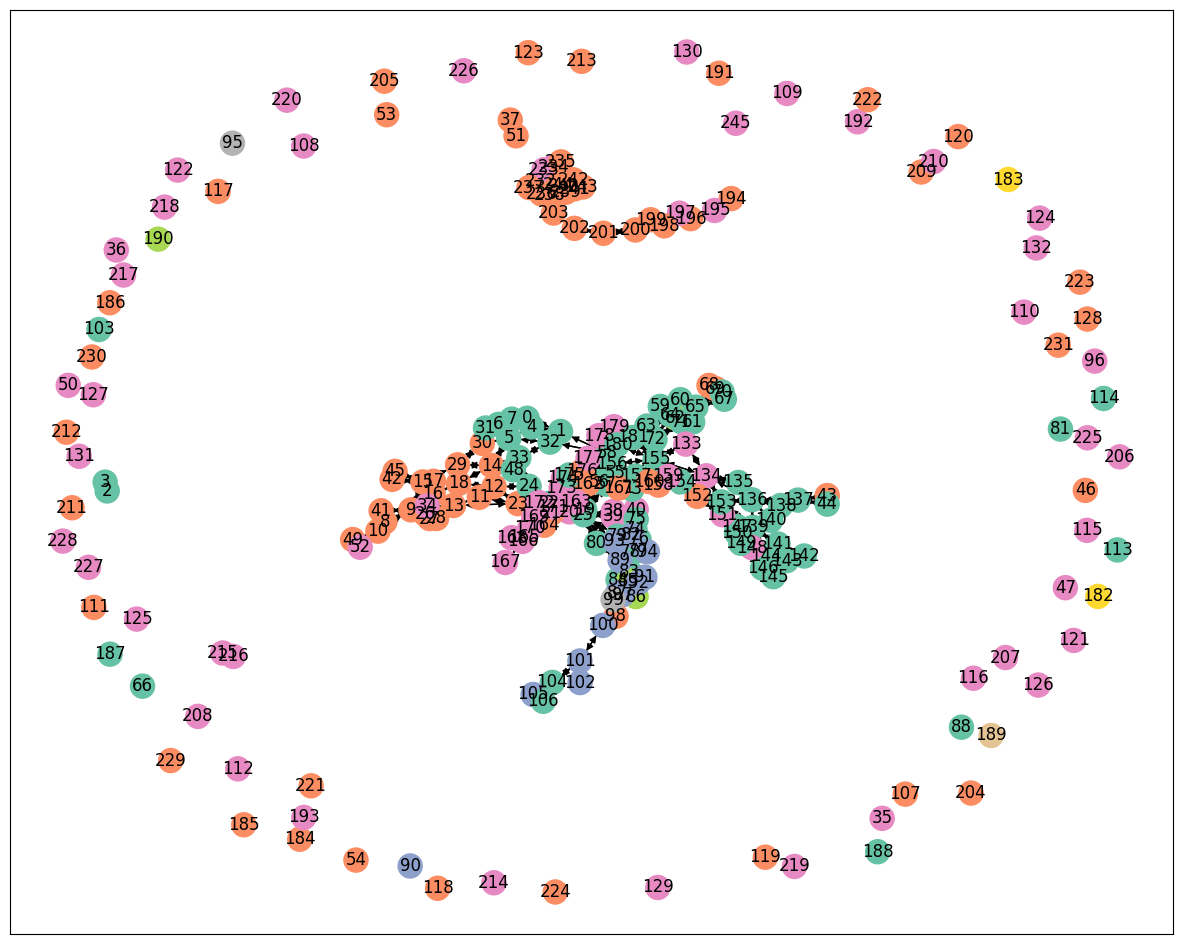

In [7]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

mon_dataset_undirected_graph = to_networkx(dataset)
visualize_graph(mon_dataset_undirected_graph, color=dataset.y)

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [8]:
num_classes = len(torch.unique(dataset.y))
print("Nombre de classes :", num_classes)


Nombre de classes : 11


In [9]:
import torch
import numpy as np

# Fixez la graine aléatoire pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)

# Assurez-vous que la taille des masques correspond à la taille de votre graphe
num_nodes = len(dataset.x)

# Créez des masques aléatoires pour chaque ensemble
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Générez des indices aléatoires pour les ensembles d'entraînement, de validation et de test
train_indices = np.random.choice(num_nodes, size=180, replace=False)
val_indices = np.random.choice([idx for idx in range(num_nodes) if idx not in train_indices], size=30, replace=False)
test_indices = np.random.choice([idx for idx in range(num_nodes) if idx not in train_indices and idx not in val_indices], size=36, replace=False)

# Remplissez les masques avec les indices générés
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# Définissez les masques dans votre ensemble de données
dataset.train_mask = train_mask
dataset.val_mask = val_mask
dataset.test_mask = test_mask


In [10]:
from torch_geometric.nn import GCNConv
from torch.nn import functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.05, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=9)
print(model)

GCN(
  (conv1): GCNConv(10, 9)
  (conv2): GCNConv(9, 11)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 11-dimensional node embeddings onto a 2D plane.

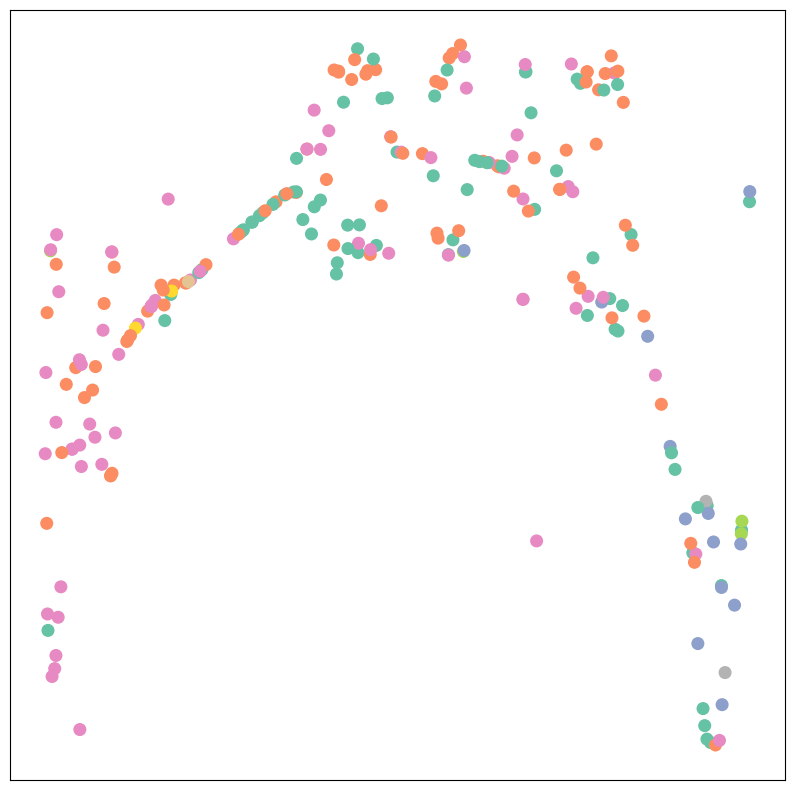

In [11]:
model = GCN(hidden_channels=8)
model.eval()

out = model(dataset.x, dataset.edge_index)
visualize(out, color=dataset.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

Epoch: 001, Loss: 21415516.0000
Epoch: 002, Loss: 20008534.0000
Epoch: 003, Loss: 17927054.0000
Epoch: 004, Loss: 16061321.0000
Epoch: 005, Loss: 14533916.0000
Epoch: 006, Loss: 12159392.0000
Epoch: 007, Loss: 10594337.0000
Epoch: 008, Loss: 8863803.0000
Epoch: 009, Loss: 7095666.0000
Epoch: 010, Loss: 6013272.5000
Epoch: 011, Loss: 4950299.5000
Epoch: 012, Loss: 4403673.0000
Epoch: 013, Loss: 3644151.7500
Epoch: 014, Loss: 3949194.5000
Epoch: 015, Loss: 3480409.2500
Epoch: 016, Loss: 3510935.0000
Epoch: 017, Loss: 3241467.0000
Epoch: 018, Loss: 3441515.5000
Epoch: 019, Loss: 3025166.7500
Epoch: 020, Loss: 3089484.5000
Epoch: 021, Loss: 2625032.2500
Epoch: 022, Loss: 2895489.7500
Epoch: 023, Loss: 2690673.2500
Epoch: 024, Loss: 2178961.2500
Epoch: 025, Loss: 2166129.5000
Epoch: 026, Loss: 2179716.2500
Epoch: 027, Loss: 2298543.2500
Epoch: 028, Loss: 2345579.5000
Epoch: 029, Loss: 1786144.1250
Epoch: 030, Loss: 1846676.0000
Epoch: 031, Loss: 1615974.6250
Epoch: 032, Loss: 1184065.5000
E

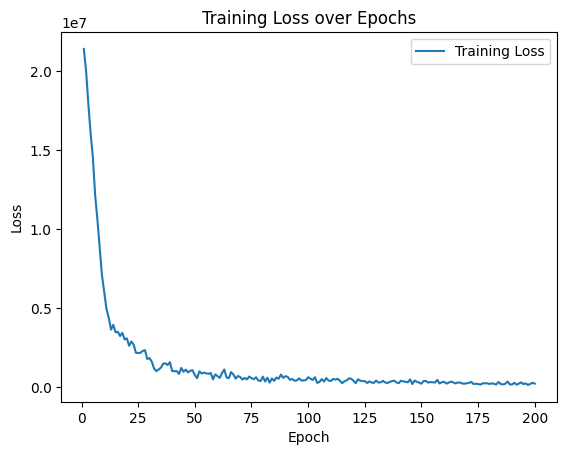

In [12]:

from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
loss_values = []

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(dataset.x, dataset.edge_index)  # Perform a single forward pass.
      loss = criterion(out, dataset.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(dataset.x, dataset.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc



# Initialiser une liste pour stocker les valeurs de la perte au fil des époques
loss_values = []

# Définir le seuil d'arrêt anticipé
seuil = 1e-4

# Initialiser une variable pour stocker la perte de l'époque précédente
previous_loss = float('inf')

for epoch in range(1, 201):
    loss = train()
    loss_values.append(loss.item())  # Ajouter la valeur de la perte à la liste
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    
    # Vérifier s'il faut arrêter tôt en comparant la diminution de la perte avec le seuil
    if epoch > 1:
        loss_decrease = previous_loss - loss.item()
        if np.abs(loss_decrease) < seuil:
            print(f'Early stopping at epoch {epoch} due to loss decrease < seuil')
            break
    
    # Mettre à jour la perte précédente pour la prochaine itération
    previous_loss = loss.item()

# Tracer la perte au fil des époques
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_train_accuracy():
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    train_correct = pred[dataset.train_mask] == dataset.y[dataset.train_mask]
    train_acc = int(train_correct.sum()) / int(dataset.train_mask.sum())
    return train_acc

def test():
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[dataset.test_mask] == dataset.y[dataset.test_mask]
    test_acc = int(test_correct.sum()) / int(dataset.test_mask.sum())
    return test_acc

def evaluate():
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    y_true = dataset.y[dataset.test_mask].numpy()
    y_pred = pred[dataset.test_mask].numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=1
    )
    return precision, recall, f1

train_acc = calculate_train_accuracy()
print(f'Accuracy on training set: {train_acc}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

precision, recall, f1 = evaluate()
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Accuracy on training set: 0.2833333333333333
Test Accuracy: 0.2222
Precision: 0.6398, Recall: 0.2222, F1 Score: 0.1902


In [14]:
def calculate_train_accuracy():
    model.eval()  # Mettre le modèle en mode évaluation.
    out = model(dataset.x, dataset.edge_index)  # Prédictions sur l'ensemble d'entraînement.
    pred = out.argmax(dim=1)  # Sélectionnez les classes avec les probabilités les plus élevées.
    train_correct = pred[dataset.train_mask] == dataset.y[dataset.train_mask]  # Comparaison avec les étiquettes réelles.
    train_acc = int(train_correct.sum()) / int(dataset.train_mask.sum())  # Précision : nombre de prédictions correctes divisé par le nombre total d'échantillons d'entraînement.
    return train_acc

# Calculer et imprimer la précision d'entraînement
train_acc = calculate_train_accuracy()
print(f'Accuracy on training set: {train_acc}')


Accuracy on training set: 0.2833333333333333


In [15]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.2222


In [16]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate():
    model.eval()
    out = model(dataset.x, dataset.edge_index)
    pred = out.argmax(dim=1)
    y_true = dataset.y[dataset.test_mask].numpy()
    y_pred = pred[dataset.test_mask].numpy()
    
    # Utilisation de zero_division=1 pour éviter les divisions par zéro
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=1
    )
    
    return precision, recall, f1

# Exécution de la fonction d'évaluation
precision, recall, f1 = evaluate()

# Affichage des résultats
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Precision: 0.6398, Recall: 0.2222, F1 Score: 0.1902


In [17]:
##### model.eval()

#out = model(dataset.x, dataset.edge_index)
#visualize(out, color=dataset.y)
# Passez vos données à travers le modèle
with torch.no_grad():
    out = model(dataset.x, dataset.edge_index)

# Obtenez les embeddings des nœuds
embeddings = out
print(embeddings[210])

# Obtenez les poids appris de la première couche de convolution
# Obtenez les poids appris de la première couche de convolution
weights_conv1 = next(model.conv1.parameters())
#weights_conv1

# Obtenez les poids appris de la deuxième couche de convolution
#weights_conv2 = model.conv2.weight

tensor([552218.5000, 528278.0625, 521636.4688, 546832.8125, 521244.1562,
        432557.5312, 205771.4062, 104876.2578, 377366.6875, 420032.4375,
        476706.9062])


In [18]:
# Supposons que 'node_index' est l'index du nœud dont on veut prédire la classe
node_index = 1

# Passage avant (Forward pass) pour obtenir les logits de sortie
model.eval()  # Mettre le modèle en mode évaluation
with torch.no_grad():
    logits = model(dataset.x, dataset.edge_index)

# Appliquer la fonction softmax pour obtenir les probabilités de classe
probabilities = torch.softmax(logits, dim=1)
# Obtenir la prédiction de classe pour le nœud donné
predicted_class = torch.argmax(probabilities[node_index]).item()

print("Classe prédite pour le nœud", node_index, ":", predicted_class)


Classe prédite pour le nœud 1 : 0


In [19]:
#  pour augmenter la limite du cache à 2000 entrées
%config DisplayHook.cache_size = 2000


In [20]:
from torch_geometric.explain import Explainer,GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

In [21]:
from torch_geometric.explain import Explainer,GNNExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)
from IPython.display import Image, display
node_index = 5
explanation = explainer(dataset.x, dataset.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=5)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [22]:
from IPython.display import Image, display
node_index = 5
explanation = explainer(dataset.x, dataset.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=5)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
Subgraph visualization plot has been saved to 'subgraph.pdf'


In [23]:
# Sélectionnez le nœud de votre choix
node_index = 0

# Obtenez le masque de nœud à partir de l'explication
node_mask = explanation.node_mask

# Trouvez l'indice de la caractéristique la plus importante dans le masque de nœud pour le nœud spécifié
most_important_feature_index = node_mask[node_index].argmax()

# Affichez la caractéristique la plus importante
print(f"La caractéristique la plus importante pour le nœud {node_index} est la caractéristique {most_important_feature_index}.")

# Maintenant, utilisez les identifiants de nœuds pour extraire les vraies valeurs de x et y à partir de vos données
# Assurez-vous que node_index est valide, c'est-à-dire qu'il se situe dans la plage des nœuds de votre dataset

# Obtenez les caractéristiques du nœud spécifié
node_features = dataset.x[node_index]

# Obtenez l'étiquette (religion) du nœud spécifié
node_label = dataset.y[node_index]

# Maintenant, vous pouvez imprimer les vraies valeurs de x et y
#print("Caractéristiques du nœud spécifié :", node_features)


La caractéristique la plus importante pour le nœud 0 est la caractéristique 2.


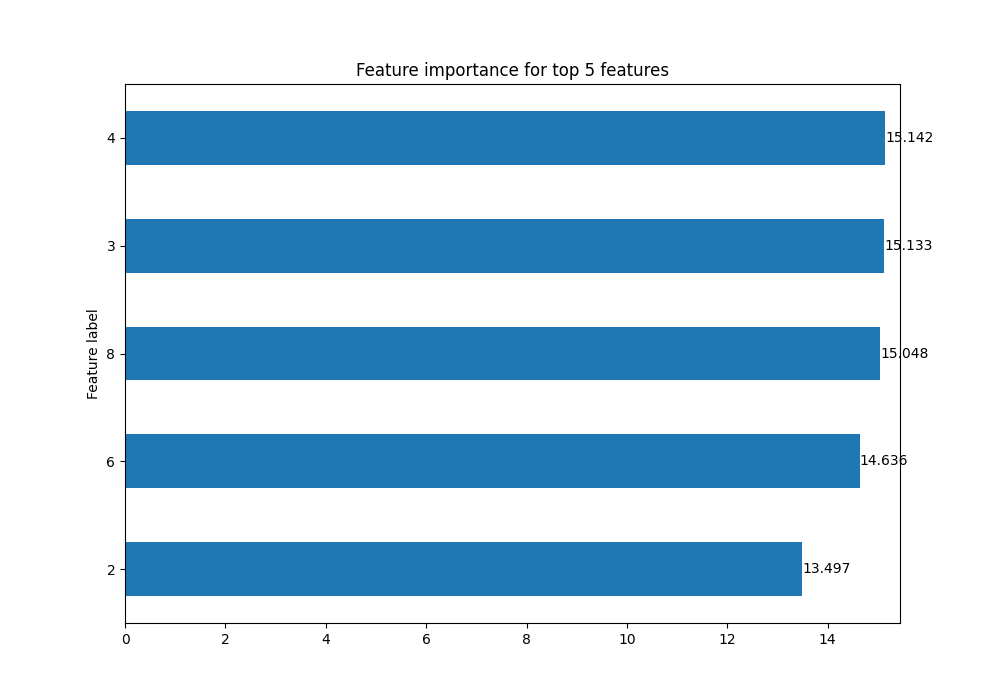

In [24]:

from IPython.display import Image
Image(filename='feature_importance.png')


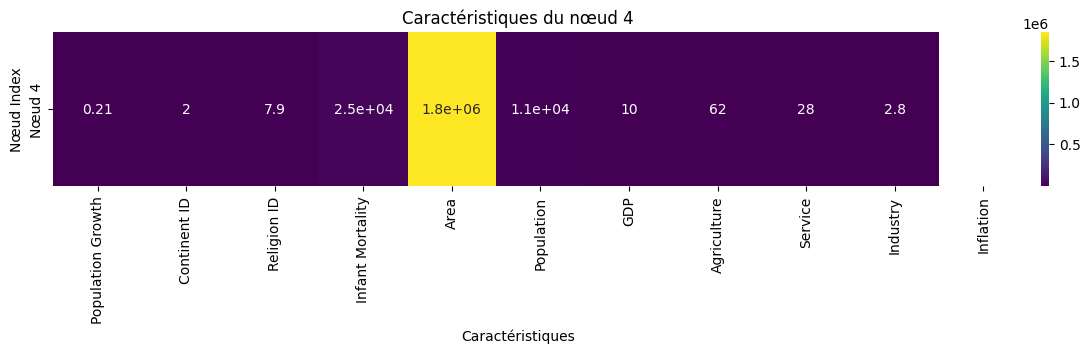

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remplacez 'features' par votre matrice des caractéristiques des nœuds, par exemple 'x'
features = dataset.x.numpy()  # Assurez-vous d'avoir le bon objet pour 'dataset'

node_index = 4 # Changer pour l'index du nœud souhaité

# Sélectionnez les caractéristiques pour un seul nœud spécifique
node_features = features[node_index, :].reshape(1, -1)  # Reshape pour le format de seaborn

# Noms des caractéristiques basés sur la description ci-dessus
feature_names = ['Population Growth', 'Continent ID', 'Religion ID', 'Infant Mortality', 'Area', 'Population', 'GDP', 'Agriculture', 'Service', 'Industry', 'Inflation']

plt.figure(figsize=(15, 2))  # Ajustez la taille comme nécessaire
sns.heatmap(node_features, annot=True, cmap='viridis', cbar=True,
            xticklabels=feature_names, yticklabels=[f'Nœud {node_index}'])
plt.title(f'Caractéristiques du nœud {node_index}')
plt.xlabel('Caractéristiques')
plt.ylabel('Nœud Index')
plt.show()


In [26]:
non_zero_indices = torch.nonzero(node_mask)
non_zero_indices


tensor([[ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  7],
        [ 1,  8],
        [ 1,  9],
        [ 4,  0],
        [ 4,  1],
        [ 4,  2],
        [ 4,  3],
        [ 4,  4],
        [ 4,  5],
        [ 4,  6],
        [ 4,  7],
        [ 4,  8],
        [ 4,  9],
        [ 5,  0],
        [ 5,  1],
        [ 5,  2],
        [ 5,  3],
        [ 5,  4],
        [ 5,  5],
        [ 5,  6],
        [ 5,  7],
        [ 5,  8],
        [ 5,  9],
        [ 6,  0],
        [ 6,  1],
        [ 6,  3],
        [ 6,  4],
        [ 6,  5],
        [ 6,  6],
        [ 6,  7],
        [ 6,  8],
        [ 6,  9],
        [ 7,  1],
        [ 7,  3],
        [ 7,  4],
        [ 7,  5],
        [ 7,  6],
        [ 7,  7],
        [ 

In [27]:
edge_mask=explanation.edge_mask
edge_mask #  Les valeurs dans ce masque représentent l'importance de chaque arête pour la classification des nœuds

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.8847, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8848, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9016,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8988, 0.0000,
        0.8910, 0.0000, 0.8907, 0.0000, 0.0000, 0.8842, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [28]:
import torch
from torch_geometric.data import Data

# Supposons que dataset contienne votre ensemble de données PyG

# Obtenir le degré de chaque nœud
degrees = torch.zeros(dataset.num_nodes)
for src, dst in dataset.edge_index.t().tolist():
    degrees[src] += 1
    #degrees[dst] += 1

# Obtenir les nœuds adjacents à chaque nœud
adj_nodes = {}
for i in range(dataset.num_nodes):
    adj_nodes[i] = []
for src, dst in dataset.edge_index.t().tolist():
    adj_nodes[src].append(dst)
    #adj_nodes[dst].append(src)  # Si le graphe est non-dirigé

# Afficher les degrés et les nœuds adjacents
for i in range(dataset.num_nodes):
    print(f"Nœud {i} - Degré : {degrees[i]}, Adjacents : {adj_nodes[i]}")


Nœud 0 - Degré : 4.0, Adjacents : [1, 4, 6, 7]
Nœud 1 - Degré : 4.0, Adjacents : [0, 32, 4, 58]
Nœud 2 - Degré : 1.0, Adjacents : [3]
Nœud 3 - Degré : 1.0, Adjacents : [2]
Nœud 4 - Degré : 5.0, Adjacents : [7, 0, 1, 5, 32]
Nœud 5 - Degré : 8.0, Adjacents : [6, 4, 7, 32, 14, 33, 30, 31]
Nœud 6 - Degré : 5.0, Adjacents : [30, 31, 7, 0, 5]
Nœud 7 - Degré : 4.0, Adjacents : [0, 4, 5, 6]
Nœud 8 - Degré : 2.0, Adjacents : [10, 9]
Nœud 9 - Degré : 8.0, Adjacents : [16, 10, 15, 41, 26, 13, 8, 27]
Nœud 10 - Degré : 4.0, Adjacents : [49, 9, 8, 52]
Nœud 11 - Degré : 4.0, Adjacents : [13, 12, 18, 23]
Nœud 12 - Degré : 5.0, Adjacents : [23, 14, 24, 18, 11]
Nœud 13 - Degré : 9.0, Adjacents : [34, 9, 18, 28, 11, 26, 27, 16, 23]
Nœud 14 - Degré : 7.0, Adjacents : [29, 5, 33, 30, 24, 12, 18]
Nœud 15 - Degré : 6.0, Adjacents : [9, 45, 18, 42, 16, 29]
Nœud 16 - Degré : 5.0, Adjacents : [15, 9, 13, 17, 18]
Nœud 17 - Degré : 2.0, Adjacents : [18, 16]
Nœud 18 - Degré : 8.0, Adjacents : [12, 11, 29, 16, 14, 

### visualisation

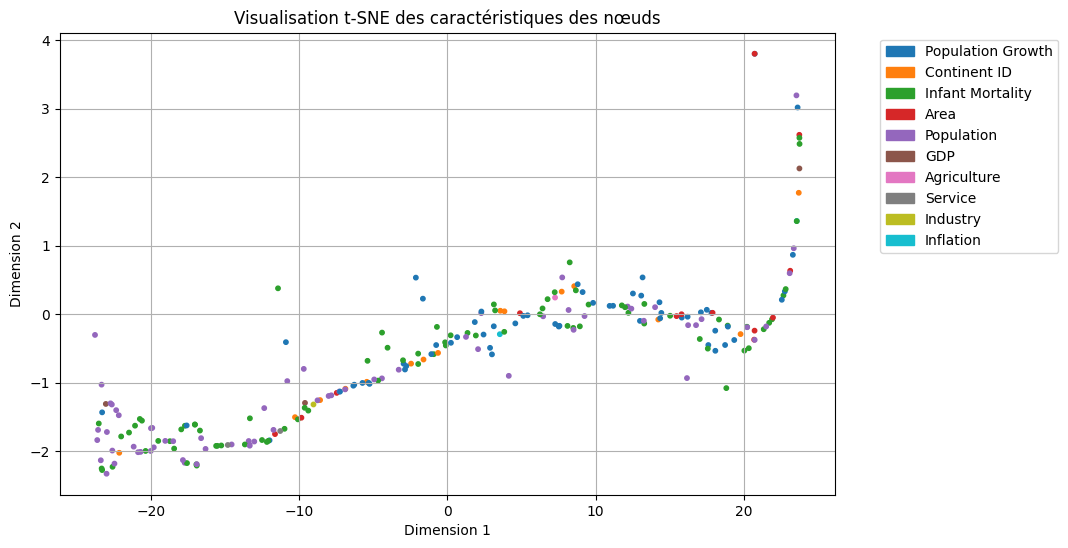

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Liste des noms de caractéristiques
feature_names = ['Population Growth', 'Continent ID', 'Infant Mortality', 'Area', 'Population', 'GDP', 'Agriculture', 'Service', 'Industry', 'Inflation']

# Réduire les dimensions des caractéristiques des nœuds en utilisant t-SNE
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(dataset.x.numpy())

# Afficher la visualisation t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=dataset.y.numpy(), cmap='tab10', s=10)
plt.title('Visualisation t-SNE des caractéristiques des nœuds')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Légende des caractéristiques
legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(value)), label=name) for value, name in zip(np.unique(dataset.y.numpy()), feature_names)]
plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.grid(True)
plt.show()


In [30]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Dictionnaire pour stocker l'attribut le plus important pour chaque nœud
node_attribute_map = {}

# Parcourir chaque nœud et obtenir l'attribut le plus important
for node_index in range(len(dataset.x)):
    explanation = explainer(dataset.x, dataset.edge_index, index=node_index)
    attribute = explanation.get_most_important_feature()
    node_attribute_map[node_index] = attribute

# Définir une palette de couleurs à partir de Seaborn
palette = sns.color_palette("husl", len(set(node_attribute_map.values())))

# Créer un dictionnaire de correspondance attribut-couleur
attribute_colors = dict(zip(sorted(set(node_attribute_map.values())), palette))

# Créer la visualisation du graphe avec les couleurs d'attribut
plt.figure(figsize=(10, 8))
for node_index in range(len(dataset.x)):
    attribute = node_attribute_map[node_index]
    color = attribute_colors.get(attribute, 'gray')  # Couleur par défaut pour les attributs non définis
    plt.scatter(embeddings[node_index, 0], embeddings[node_index, 1], color=color)

# Afficher la légende pour les couleurs d'attribut
for attribute, color in attribute_colors.items():
    plt.scatter([], [], color=color, label=attribute)
plt.legend()

# Afficher la visualisation
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Node Embeddings Colored by Most Important Feature')
plt.show()


AttributeError: 'GlobalStorage' object has no attribute 'get_most_important_feature'

In [ ]:
"""from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

def extract_most_important_feature(image_path):
    # Charger l'image
    img = Image.open(image_path)
    # Convertir l'image en tableau numpy
    img_array = np.array(img)
    # Identifier les barres dans l'image et mesurer leur hauteur
    bar_heights = [sum(row == 255) for row in img_array] 
    # Trouver l'indice de la barre la plus haute (caractéristique la plus importante)
    most_important_feature_index = np.argmax(bar_heights)
    return most_important_feature_index

# Dictionnaire pour stocker l'attribut le plus important pour chaque nœud
node_attribute_map = {}

# Parcourir chaque nœud et obtenir l'attribut le plus important
for node_index in range(len(dataset.x)):
    explanation = explainer(dataset.x, dataset.edge_index, index=node_index)
    path = f'feature_importance_node_{node_index}.png'
    explanation.visualize_feature_importance(path)
    most_important_feature_index = extract_most_important_feature(path)
    node_attribute_map[node_index] = most_important_feature_index

# Définir une palette de couleurs à partir de Seaborn
palette = sns.color_palette("husl", len(set(node_attribute_map.values())))

# Créer un dictionnaire de correspondance attribut-couleur
attribute_colors = dict(zip(sorted(set(node_attribute_map.values())), palette))
print(node_attribute_map[10])
# Créer la visualisation du graphe avec les couleurs d'attribut
plt.figure(figsize=(10, 8))
for node_index in range(len(dataset.x)):
    attribute = node_attribute_map[node_index]
    color = attribute_colors.get(attribute, 'gray')  # Couleur par défaut pour les attributs non définis
    plt.scatter(embeddings[node_index, 0], embeddings[node_index, 1], color=color)

# Afficher la légende pour les couleurs d'attribut
for attribute, color in attribute_colors.items():
    plt.scatter([], [], color=color, label=attribute)
plt.legend()

# Afficher la visualisation
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Node Embeddings Colored by Most Important Feature')
plt.show()


In [ ]:
most_important_feature_index